## Import Library

In [1]:
import osmnx as ox
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from datetime import datetime
import shapely.geometry as sg

## Load map from OSM

In [2]:
places = [
    'District 1, Ho Chi Minh City, Vietnam',
    'District 4, Ho Chi Minh City, Vietnam',
    'District 7, Ho Chi Minh City, Vietnam'
]

with tqdm(total=3, desc="Graph Setup") as pbar:
    # Step 1: Download the graph (The main bottleneck)
    pbar.set_description("Graph Setup: Downloading Graph from OSM")
    G = ox.graph_from_place(places, network_type='drive')
    pbar.update(1) # Mark step 1 complete

    # Step 2: Project the graph (CRS conversion)
    pbar.set_description("Graph Setup: Projecting Graph")
    # This is essential for accurate distance calculations used in map matching.
    G_proj = ox.project_graph(G)
    pbar.update(1) # Mark step 2 complete

    # Step 3: Convert to GeoDataFrames
    pbar.set_description("Graph Setup: Converting to GeoDataFrames")
    nodes, edges = ox.graph_to_gdfs(G_proj)
    edges = edges.reset_index()
    pbar.update(1) # Mark step 3 complete

    # Step 4: Compress node IDS
    pbar.set_description("Graph Setup: Compressing Node IDs")
    node_id_map = {osm_id: new_id for new_id, osm_id in enumerate(nodes.index)}
    
    edges['u_compressed'] = edges['u'].map(node_id_map)
    edges['v_compressed'] = edges['v'].map(node_id_map)
    edges['maxspeed'] = pd.to_numeric(edges['maxspeed'].fillna(40), errors = 'coerce')

    nodes['compressed_id'] = nodes.index.map(node_id_map)    
    pbar.update(1) # Mark step 4 complete

Graph Setup: Compressing Node IDs: : 4it [00:13,  3.27s/it]                            


In [3]:
edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9748 entries, 0 to 9747
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   u             9748 non-null   int64   
 1   v             9748 non-null   int64   
 2   key           9748 non-null   int64   
 3   osmid         9748 non-null   object  
 4   highway       9748 non-null   object  
 5   oneway        9748 non-null   bool    
 6   reversed      9748 non-null   object  
 7   length        9748 non-null   float64 
 8   lanes         3809 non-null   object  
 9   maxspeed      9738 non-null   float64 
 10  name          7990 non-null   object  
 11  geometry      9748 non-null   geometry
 12  bridge        141 non-null    object  
 13  junction      67 non-null     object  
 14  access        49 non-null     object  
 15  tunnel        7 non-null      object  
 16  width         1 non-null      object  
 17  u_compressed  9748 non-null   int64   
 18  

In [4]:
nodes.head()

,y,x,street_count,highway,ref,geometry,compressed_id
osmid,,,,,,,
366367242,1.184376e+06,689988.041075,3,NaN,NaN,POINT (689988.041 1184376.343),0
2299061014,1.184376e+06,689997.482313,3,NaN,NaN,POINT (689997.482 1184376.341),1
7802319894,1.184140e+06,690001.690106,3,NaN,NaN,POINT (690001.69 1184140.247),2
366368084,1.188139e+06,687394.507201,4,NaN,NaN,POINT (687394.507 1188139.185),3
366375264,1.188141e+06,687634.225882,4,NaN,NaN,POINT (687634.226 1188141.475),4


In [5]:
print(f'Number of nodes: {len(nodes)}')
print(f'Number of edges: {len(edges)}')

Number of nodes: 4084
Number of edges: 9748


In [6]:
edges.crs

<Projected CRS: EPSG:32648>
Name: WGS 84 / UTM zone 48N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°E and 108°E, northern hemisphere between equator and 84°N, onshore and offshore. Cambodia. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Russian Federation. Singapore. Thailand. Vietnam.
- bounds: (102.0, 0.0, 108.0, 84.0)
Coordinate Operation:
- name: UTM zone 48N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Load GPS trajectory

In [7]:
jsonPath = 'pVehicle-all-22_03_24\\test.json'
try:
    with open(jsonPath, 'r') as f:
        rawRoute = json.load(f)
except FileNotFoundError:
    print(f'File path {jsonPath} not found')
    raise

In [8]:
def convertTimestamp (timestamp):
    # Define format string
    formatString = "%Y-%m-%dT%H:%M:%S%z"
    
    # Parse the string into a timezone-aware datetime object
    dtObject = datetime.strptime(timestamp, formatString)
    
    # Convert the datetime object to a POSIX timestamp (seconds since Epoch).
    seconds_since_epoch = int(dtObject.timestamp())
    
    return seconds_since_epoch

timestamp = "2022-03-24T15:59:35+07:00"
seconds = convertTimestamp(timestamp)

print(f"Input string: {timestamp}")
print(f"Seconds since Epoch: {seconds}")

Input string: 2022-03-24T15:59:35+07:00
Seconds since Epoch: 1648112375


In [21]:
pointList = rawRoute['tripList'][0]['pointList']
timeStampList = rawRoute['tripList'][0]['timeStampList']
distList = rawRoute['tripList'][0]['distanceList']

In [22]:
trajectoryData, counter = [], 0
for i in range(0, len(pointList), 2):
    lat, lng, time = pointList[i + 1], pointList[i], counter
    counter += 30
    trajectoryData.append({
        'lat': lat,
        'lng': lng,
        'time': time,
    })

In [23]:
dfTrajectory = pd.DataFrame(trajectoryData)
dfTrajectory['geometry'] = dfTrajectory.apply(
    lambda row: Point(row['lng'], row['lat']),
    axis = 1
)
dfTrajectory.head()

,lat,lng,time,geometry
0,1.187122e+06,685634.282825,0,POINT (685634.2828246017 1187121.6036664057)
1,1.187115e+06,685699.560538,30,POINT (685699.5605383165 1187115.3317848225)
2,1.187520e+06,685746.396722,60,POINT (685746.3967221772 1187520.146884101)
3,1.187651e+06,685767.981255,90,POINT (685767.9812551964 1187651.383723191)
4,1.187741e+06,685782.749620,120,POINT (685782.7496198937 1187741.177349937)


In [24]:
trajectory = gpd.GeoDataFrame(
    dfTrajectory,
    geometry = 'geometry',
    crs = edges.crs
)
trajectory.head()

,lat,lng,time,geometry
0,1.187122e+06,685634.282825,0,POINT (685634.283 1187121.604)
1,1.187115e+06,685699.560538,30,POINT (685699.561 1187115.332)
2,1.187520e+06,685746.396722,60,POINT (685746.397 1187520.147)
3,1.187651e+06,685767.981255,90,POINT (685767.981 1187651.384)
4,1.187741e+06,685782.749620,120,POINT (685782.75 1187741.177)


## Load ground truth

In [25]:
path = 'bus 1 ngay\\2022_03_27_businfo\\test.json'
df = pd.read_json(path).drop(['RouteId', 'RouteVarId'], axis = 1)
df

,lat,lng
0,10.767676,106.689362
1,10.767676,106.689362
2,10.767218,106.689560
3,10.767473,106.690224
4,10.767729,106.690895
...,...,...
479,10.894555,106.677254
480,10.893960,106.675323
481,10.893365,106.673393
482,10.892880,106.673424


In [26]:
geometry = [Point(xy) for xy in zip(df['lng'], df['lat'])]
gdf = gpd.GeoDataFrame(
    df,
    geometry = geometry,
    crs = 'EPSG:4326'
).to_crs(edges.crs)
gdf

,lat,lng,geometry
0,10.767676,106.689362,POINT (684720.427 1190800.377)
1,10.767676,106.689362,POINT (684720.427 1190800.377)
2,10.767218,106.689560,POINT (684742.403 1190749.757)
3,10.767473,106.690224,POINT (684814.844 1190778.428)
4,10.767729,106.690895,POINT (684888.12 1190807.104)
...,...,...,...
479,10.894555,106.677254,POINT (683318.933 1204827.619)
480,10.893960,106.675323,POINT (683108.272 1204760.627)
481,10.893365,106.673393,POINT (682897.61 1204693.636)
482,10.892880,106.673424,POINT (682901.242 1204640.065)


## Visualize map

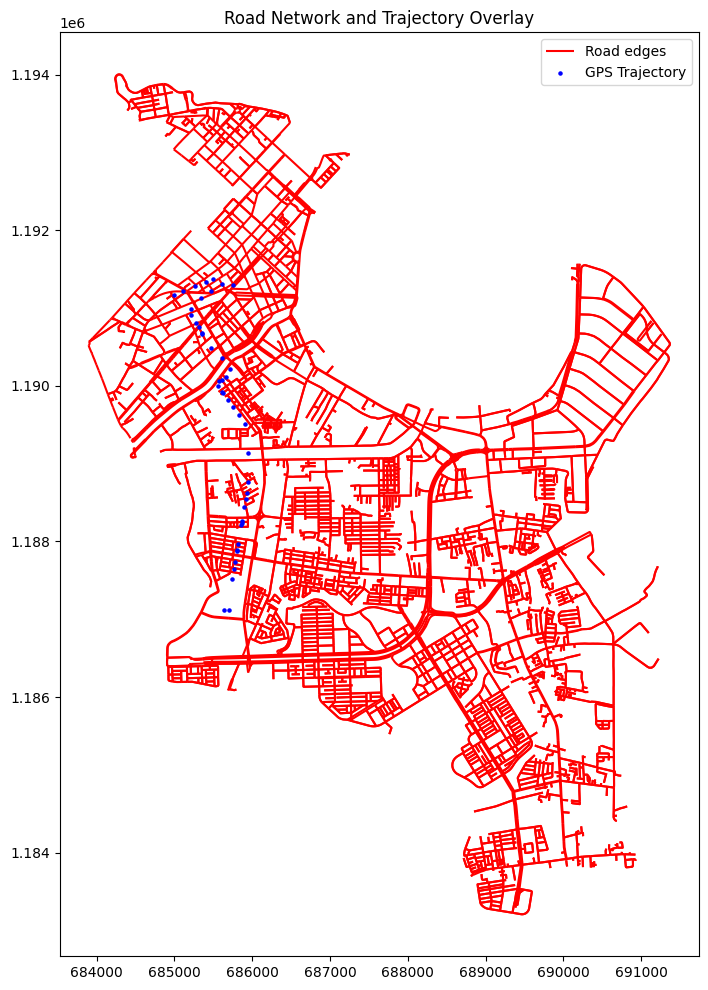

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (10, 12))
edges.plot(
    ax = ax,
    color = 'red',
    label = 'Road edges',
    zorder = 1
)
trajectory.plot(
    ax = ax,
    marker = 'o',
    color = 'blue',
    markersize = 5,
    label = 'GPS Trajectory',
    zorder = 2
)
ax.set_title('Road Network and Trajectory Overlay')
ax.legend()
plt.show()

## Export input

In [28]:
def export_network_and_trajectory (output_filename, nodes_gdf, edges_gdf, trajectory_gdf):
    """
    Exports network and trajectory data to a text file with the specified format.

    Args:
        output_filename (str): The name of the output text file.
        nodes_gdf (pd.DataFrame): The nodes GeoDataFrame (used for N).
        edges_gdf (pd.DataFrame): The edges GeoDataFrame.
        trajectory_gdf (pd.DataFrame): The trajectory GeoDataFrame.
    """
    # --- 1. Data Preparation and Parameter Calculation ---

    # Calculate N, M, K
    N = len(nodes_gdf)
    M = len(edges_gdf)
    K = len(trajectory_gdf)

    # Convert maxspeed (kph) to mps, handling NaNs
    # Default speed: 40 kph
    DEFAULT_MAXSPEED_KPH = 40.0
    KPH_TO_MPS = 1000.0 / 3600.0  # meters per second

    edges_gdf['limit_mps'] = edges_gdf['maxspeed'].fillna(DEFAULT_MAXSPEED_KPH).astype(float) * KPH_TO_MPS

    # Convert 'oneway' boolean to 0 or 1 integer
    edges_gdf['isOneway_int'] = edges_gdf['oneway'].astype(int)

    # --- 2. File Writing ---
    with open(output_filename, 'w') as f:
        # 2.1. Write the first line: N, M, K
        f.write(f"{N} {M} {K}\n")

        # 2.2. Write the next 2M lines: Edges
        # Iterate over each edge row
        for index, row in edges_gdf.iterrows():
            # Get geometry (assuming it's a Shapely LineString or similar)
            geometry = row['geometry']
            
            # Extract coordinates from the polyline
            # This handles LineStrings and extracts (x, y) coordinates
            if isinstance(geometry, sg.LineString):
                coords = list(geometry.coords)
            else:
                # Handle potential MultiLineString or other types if necessary,
                # or just use an empty list if the geometry is missing/invalid
                coords = [] 
            
            # Flatten the coordinates list into alternating x, y, x, y...
            polyline_coords_flat = [coord for point in coords for coord in point]
            
            # The length of the polyline coordinates (l) is half the total number of real numbers
            l = len(coords)

            # First line of the edge: u, v, limit, isOneway
            u = row['u_compressed']
            v = row['v_compressed']
            limit = row['limit_mps']
            is_oneway = row['isOneway_int']
            f.write(f"{u} {v} {limit:.6f} {is_oneway}\n") # Use .6f for real numbers

            # Second line of the edge: l followed by 2l real numbers
            # Use space separation for all elements
            # Join the flattened list of coordinates into a single string
            coords_string = " ".join([f"{c:.6f}" for c in polyline_coords_flat])
            f.write(f"{l} {coords_string}\n")

        # 2.3. Write the next K lines: Trajectory points
        # Each line: lat, lng, time
        for index, row in trajectory_gdf.iterrows():
            lat = row['lat']
            lng = row['lng']
            time = row['time'] # Assuming time is already a numerical type (timestamp or float)
            f.write(f"{lng:.6f} {lat:.6f} {time:.6f}\n")

    print(f"Successfully exported data to '{output_filename}'.")

In [29]:
export_network_and_trajectory('network.inp', nodes, edges, trajectory)

Successfully exported data to 'network.inp'.


## Visualize output

In [30]:
# read from output file
outputPath = 'output.txt'
with open(outputPath, 'r') as f:
    K, matchedCoords = int(f.readline().strip()), []
    for i in range(K):
        line = f.readline().strip()
        point = [float(p) for p in line.split()]
        matchedCoords.append((point[0], point[1]))

geometry = [Point(xy) for xy in matchedCoords]
matchedTrajectory = gpd.GeoDataFrame(
    pd.DataFrame({'id': range(len(geometry))}),
    geometry = geometry,
    crs = edges.crs
)
matchedTrajectory

,id,geometry
0,0,POINT (685696.876 1187019.261)
1,1,POINT (685534.779 1187031.839)
2,2,POINT (685521.548 1187033.005)
3,3,POINT (685511.807 1187033.925)
4,4,POINT (685510.425 1187024.681)
...,...,...
738,738,POINT (685023.984 1191119.13)
739,739,POINT (685008.984 1191108.185)
740,740,POINT (685002.703 1191116.468)
741,741,POINT (684977.682 1191149.482)


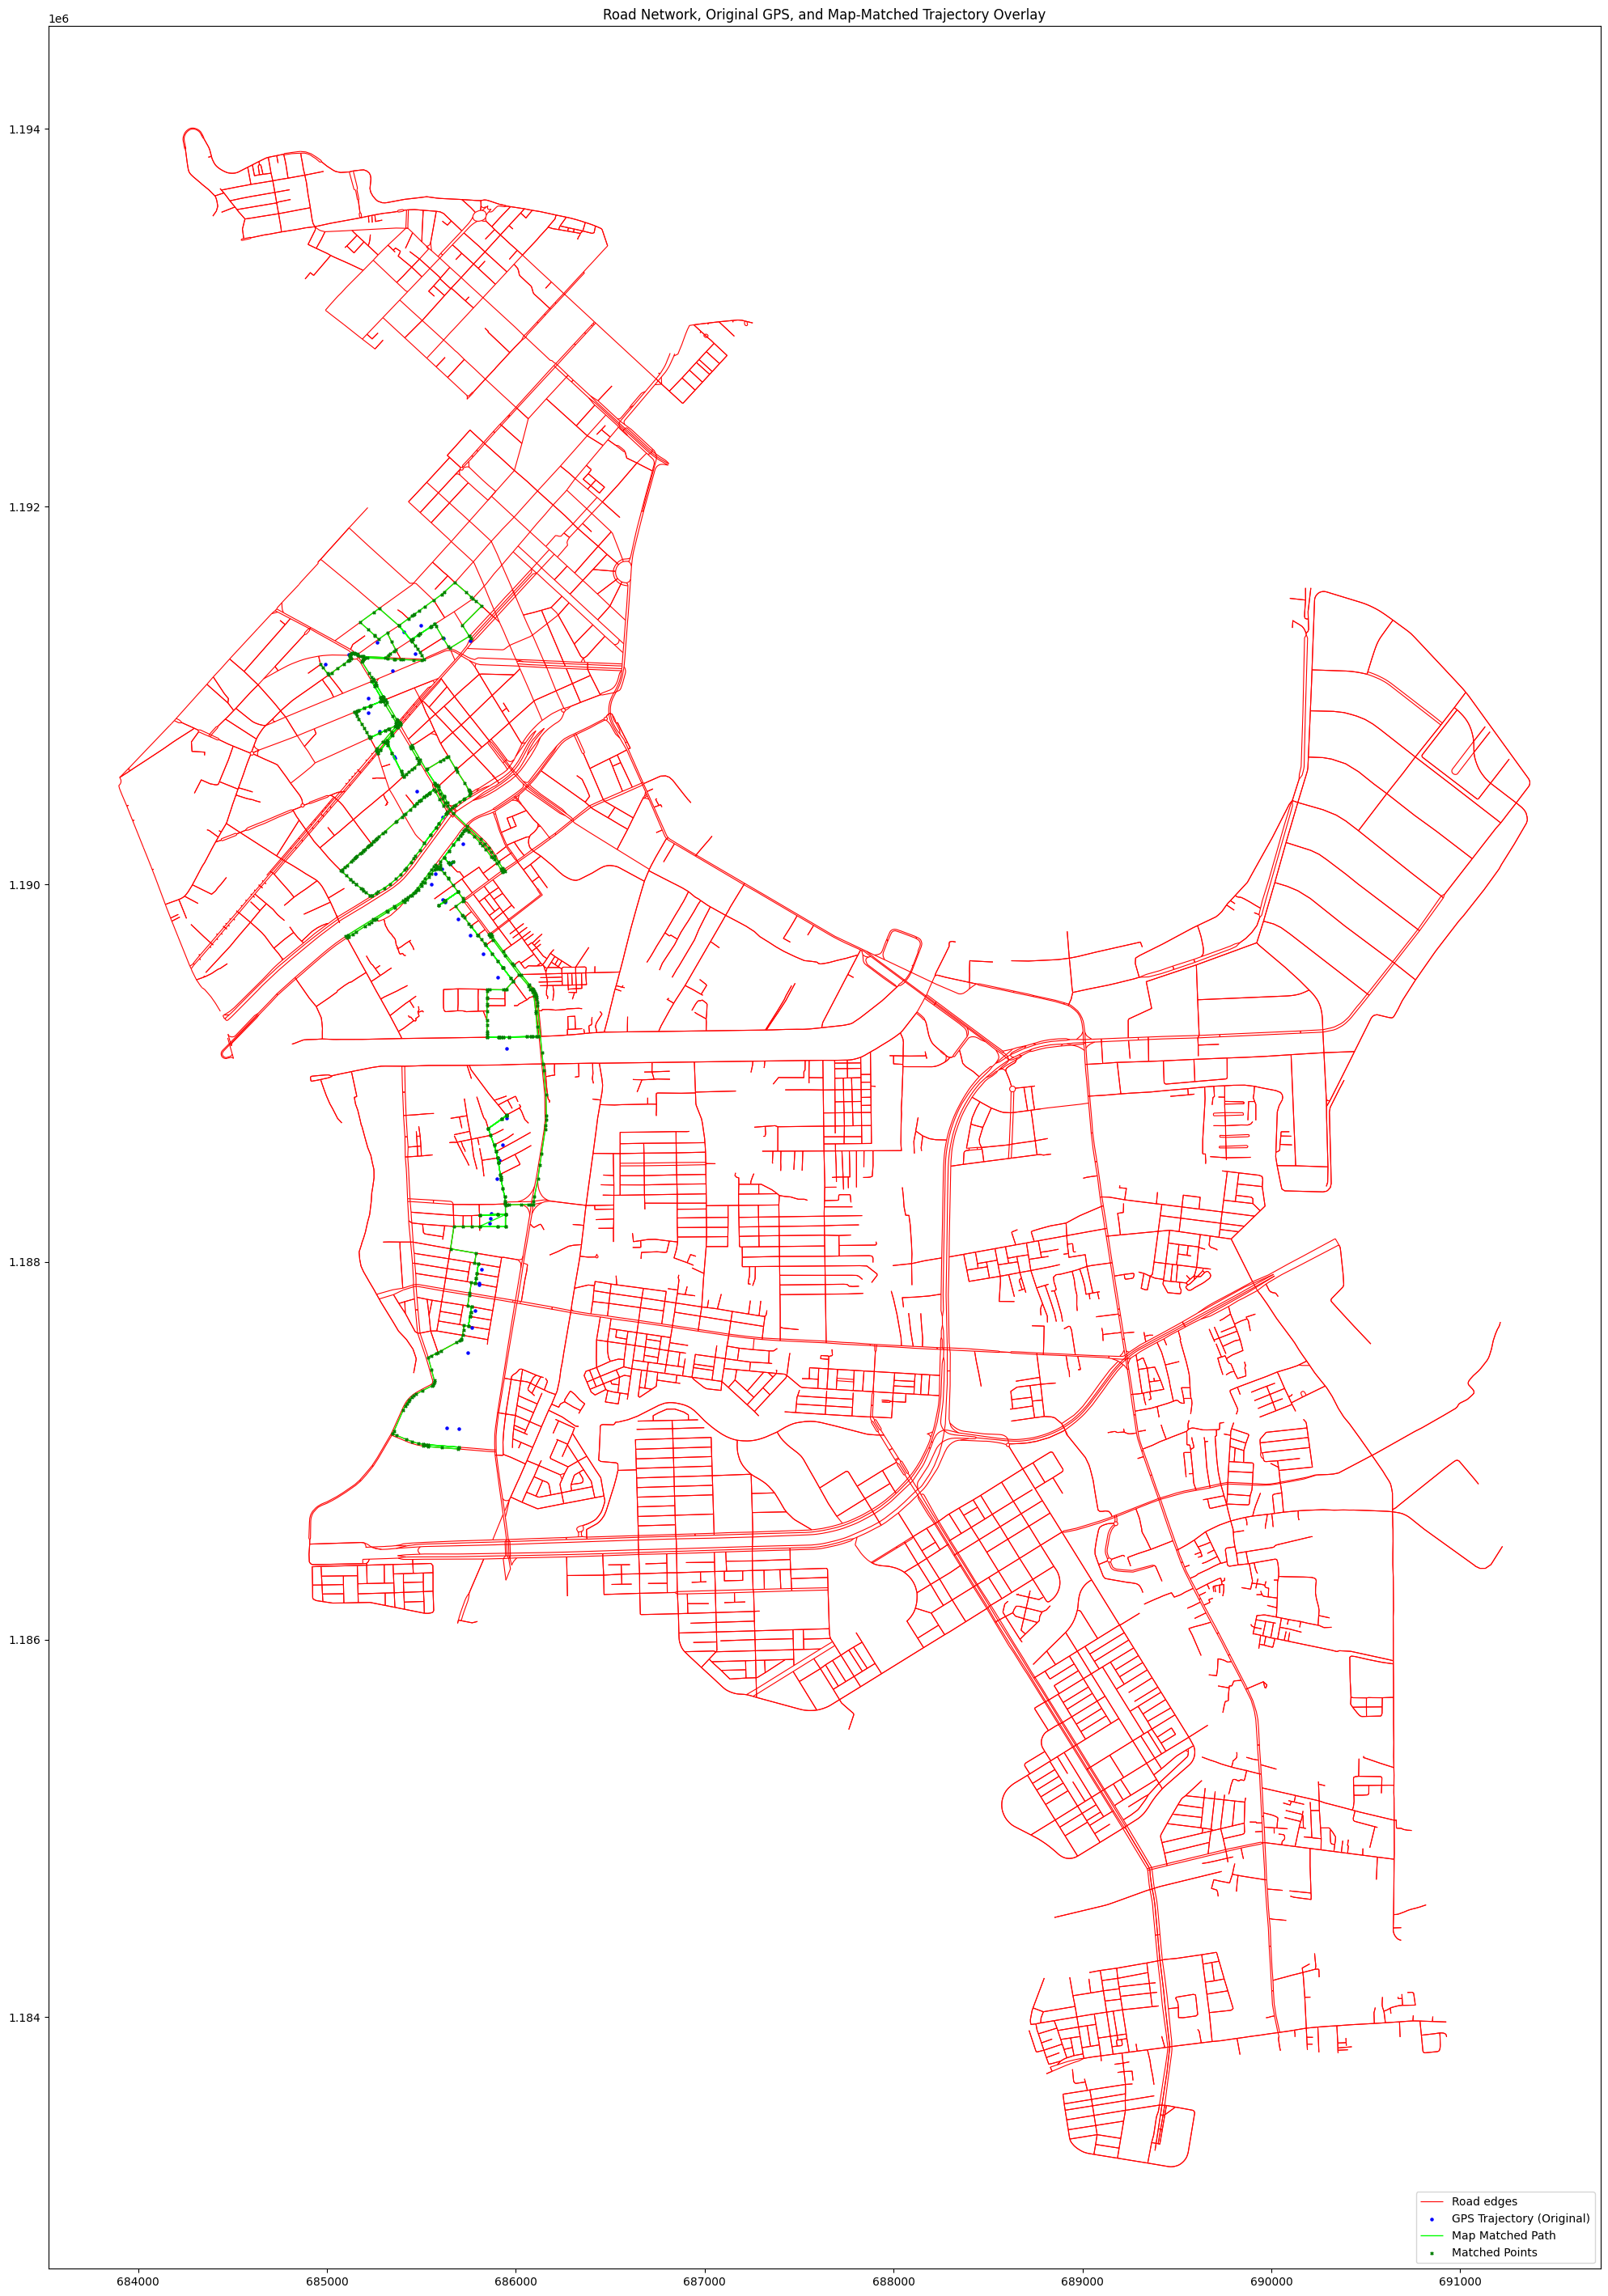

In [31]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString, Point
# Assuming 'matchedTrajectory' is a GeoDataFrame of Point geometries

# --- Start of Modified Plotting Code ---

fig, ax = plt.subplots(1, 1, figsize = (30, 36))

# 1. Plot the Road Edges (Unchanged)
edges.plot(
    ax = ax,
    color = 'red',
    label = 'Road edges',
    zorder = 1,
    linewidth = 0.8 # Added line width for better visibility
)

# 2. Plot the Original GPS Trajectory (Unchanged)
trajectory.plot(
    ax = ax,
    marker = 'o',
    color = 'blue',
    markersize = 5,
    label = 'GPS Trajectory (Original)',
    zorder = 2
)

# --- 3. Plot the Map-Matched Path (The FIX) ---

if len(matchedTrajectory) > 1:
    # A. Extract the ordered coordinates from the Point geometries
    # This creates a list of (x, y) tuples from the Point objects
    matched_coords_list = [(p.x, p.y) for p in matchedTrajectory.geometry]
    
    # B. Create a single LineString geometry object from the ordered coordinates
    matched_line = LineString(matched_coords_list)
    
    # C. Plot the LineString using GeoSeries.plot()
    # This is what draws the smooth, continuous line.
    gpd.GeoSeries(matched_line, crs=matchedTrajectory.crs).plot(
        ax=ax,
        color='lime',
        linewidth=1, # Use a thicker line to make it stand out
        label='Map Matched Path',
        zorder=3 # Use a higher z-order to place it clearly on top
    )

# 4. Plot the Matched Points (Markers)
# This step is optional but helpful to visualize the discrete output of the matching.
matchedTrajectory.plot(
    ax=ax,
    marker='x',
    color='green', # Use a distinct marker color
    markersize=5,
    label='Matched Points',
    zorder=4 # Highest z-order for visibility
)

# --- End of Modified Plotting Code ---

ax.set_title('Road Network, Original GPS, and Map-Matched Trajectory Overlay')
ax.legend(loc='lower right')
plt.show()